In [ ]:
#import necessary libraries
import os
import copy
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import models
from sklearn.utils import shuffle
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager
from collections import OrderedDict

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import os
print(os.getcwd())


/kaggle/working


 **understanding the dataset**

In [ ]:
if "food-101" in os.listdir():
    print("Dataset already exists")
else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz > /dev/null 2>&1
    print("Extraction done!")


--2023-11-09 14:36:54--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178

Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.

HTTP request sent, awaiting response... 302 Found

Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]

--2023-11-09 14:36:55--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.

HTTP request sent, awaiting response... 200 OK

Length: 4996278331 (4.7G) [application/x-gzip]

Saving to: ‘food-101.tar.gz’



food-101.tar.gz     100%[===================>]   4.65G  13.3MB/s    in 6m 18s  



2023-11-09 14:43:14 (12.6 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



Dataset downloaded!

Extracting data..

Extraction done!


In [ ]:
#The below  code reads a list of food classes from the file "classes.txt" located in the "food-101/meta/" directory. It then selects the first 20 classes from this list and appends an additional class called 'other'. The resulting list, named classes_21, contains 21 classes.
classes = open("./food-101/meta/classes.txt", 'r').read().splitlines()
classes_21 = classes[:20] + ['other']
classes_21, len(classes_21)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheesecake',
  'cheese_plate',
  'chicken_curry',
  'chicken_quesadilla',
  'other'],
 21)

**identifying training and testing images**

In [ ]:
#The code snippet displays the first five entries from two files, test.txt and train.txt, located in the food-101/meta/ directory. It begins by printing "Testing images," followed by the first five lines from test.txt, then prints "Training images" and shows the first five lines from train.txt. The purpose is to preview the contents of these files, likely listing image data for testing and training purposes.
!echo "Testing images"
!head -n 5 ./food-101/meta/test.txt
!echo -e "\nTraining images"
!head -n 5 ./food-101/meta/train.txt | head -n 5

Testing images

apple_pie/1011328

apple_pie/101251

apple_pie/1034399

apple_pie/103801

apple_pie/1038694



Training images

apple_pie/1005649

apple_pie/1014775

apple_pie/1026328

apple_pie/1028787

apple_pie/1043283


**exploratory data analysis (for dummies)**

In [ ]:
#The prep_df function processes a file containing relative paths of images. It:

#Reads the file and extracts image paths.
#Constructs full paths for these images using a base directory.
#Separates the label and image index from the relative paths.
#Converts this data into a pandas DataFrame with labels and full image paths.
#Shuffles the rows of the DataFrame randomly.
#Returns the shuffled DataFrame.

def prep_df(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()

    # Getting the full path for the images
    img_path = "./food-101/images/"
    full_path = [img_path + img + ".jpg" for img in array]

    # Splitting the image index from the label
    imgs = []
    for img in array:
        img = img.split('/')

        imgs.append(img)

    imgs = np.array(imgs)
    # Converting the array to a data frame
    imgs = pd.DataFrame(imgs[:,0], imgs[:,1], columns=['label'])
    # Adding the full path to the data frame
    imgs['path'] = full_path

    # Randomly shuffling the order to the data in the dataframe
    imgs = shuffle(imgs)

    return imgs

In [ ]:
#It reads data from specified files for training and testing images. The first five entries of the training images DataFrame (train_imgs) are then displayed.
train_imgs = prep_df('./food-101/meta/train.txt')
test_imgs = prep_df('./food-101/meta/test.txt')

train_imgs.head(5)

,label,path
3180815,tiramisu,./food-101/images/tiramisu/3180815.jpg
1017481,guacamole,./food-101/images/guacamole/1017481.jpg
3632083,fried_rice,./food-101/images/fried_rice/3632083.jpg
2898444,garlic_bread,./food-101/images/garlic_bread/2898444.jpg
3911030,miso_soup,./food-101/images/miso_soup/3911030.jpg


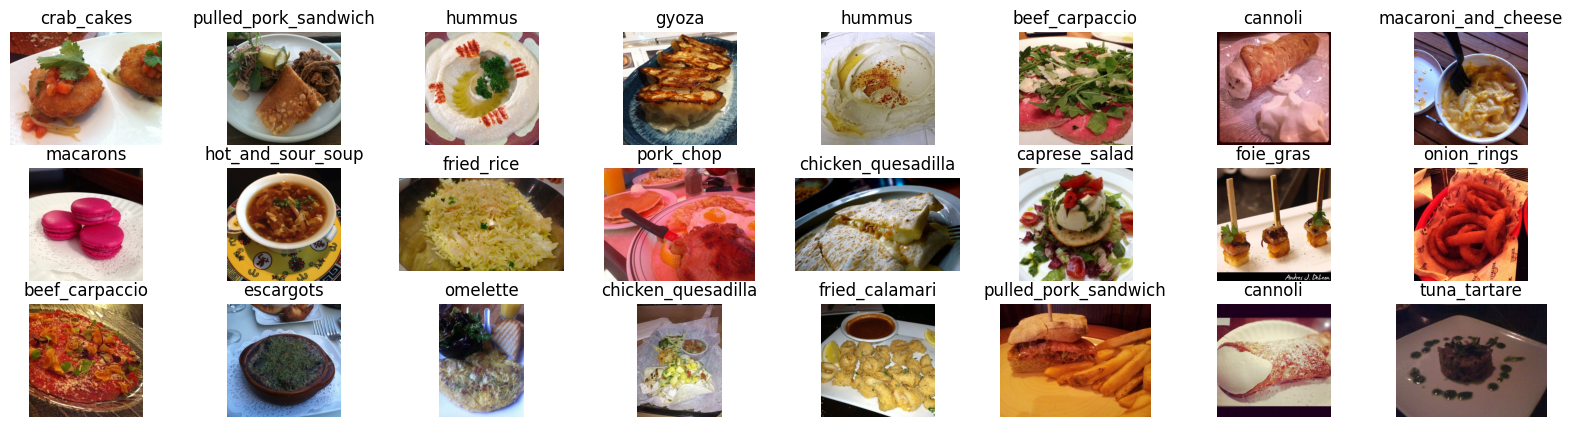

In [ ]:
#The code visualizes 24 random images from the train_imgs DataFrame. It creates a 3x8 grid and populates it with the images. Each image is accompanied by its label as a title, and the axis markings are removed for a cleaner display. The resulting visualization showcases a subset of the training dataset.
plt.figure(figsize=(20, 5))

num_rows = 3
num_cols = 8


for idx in range(num_rows * num_cols):
    random_idx = np.random.randint(0, train_imgs.shape[0])
    img = plt.imread(train_imgs.path.iloc[random_idx])

    label = train_imgs.label.iloc[random_idx]

    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

**visualization using barplot**

In [ ]:
def barplot_vis(imgs_dataframe):# Use the newly integrated Roboto font family for all text.
    fig, ax = plt.subplots()

    new_labels = [row if row in classes_21 else "other" for row in imgs_dataframe.label]
    tmp_imgs_dataframe = imgs_dataframe.copy(deep=True)
    tmp_imgs_dataframe['label'] = new_labels

    grouped_train_imgs = tmp_imgs_dataframe.groupby("label")

    heights = [grouped_train_imgs.get_group(group).shape[0] for group in classes_21]

    # Save the chart so we can loop through the bars below.
    bars = ax.bar(
        x=classes_21,
        height=heights,
        tick_label=classes_21
    )

    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)

    # Add text annotations to the top of the bars.
    bar_color = bars[0].get_facecolor()
    percentage_heights = np.array(heights) / sum(heights)
    for idx in range(len(bars)):
      ax.text(
          bars[idx].get_x() + bars[idx].get_width() / 2,
          bars[idx].get_height() + 0.3,
          round(percentage_heights[idx] * 100, 2),
          horizontalalignment='center',
          color=bar_color,
          weight='bold'
      )

    # Add labels and a title.
    ax.set_xlabel('Food Class', labelpad=15, color='#333333')
    ax.set_ylabel('Number of Images', labelpad=15, color='#333333')
    ax.set_title('Visualizing Class Imbalance', pad=15, color='#333333',
                 weight='bold')

    fig.autofmt_xdate(rotation=45)
    fig.set_size_inches(18.5, 4)

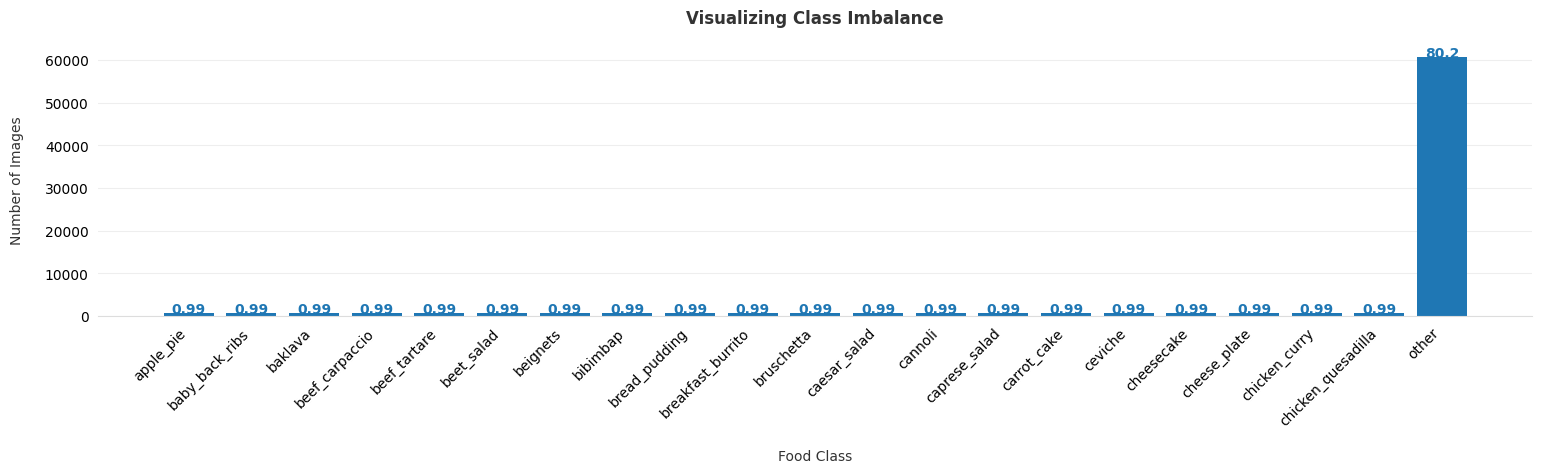

In [ ]:
barplot_vis(train_imgs)

**preparing the data for transformation**

In [ ]:
# Data augmentation for training
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
# Data augmentation for testing
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [ ]:
#The Label_encoder class provides encoding and decoding functionality for dataset labels. It maps each unique label to a corresponding index and vice versa.
class Label_encoder:
    def __init__(self, labels):
        labels = list(set(labels))
        self.labels = {label: idx for idx, label in enumerate(classes)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels[label]

encoder = Label_encoder(classes)
for i in range(20):
    print(encoder.get_label(i), encoder.get_idx( encoder.get_label(i) ))

apple_pie 0

baby_back_ribs 1

baklava 2

beef_carpaccio 3

beef_tartare 4

beet_salad 5

beignets 6

bibimbap 7

bread_pudding 8

breakfast_burrito 9

bruschetta 10

caesar_salad 11

cannoli 12

caprese_salad 13

carrot_cake 14

ceviche 15

cheesecake 16

cheese_plate 17

chicken_curry 18

chicken_quesadilla 19


In [ ]:
#The class facilitates efficient access to images and their corresponding labels, making it suitable for training/testing in PyTorch.
class Food20(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = encoder.get_idx(self.dataframe.label.iloc[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
#preparing the training and testing datasets with the appropriate image transformations to be used in the subsequent stages of a machine learning or deep learning pipeline, likely in conjunction with PyTorch's data loaders.
train_dataset = Food20(train_imgs, transform=train_transforms)
test_dataset = Food20(test_imgs, transform=test_transforms)

In [ ]:
# code initializes two data loaders using PyTorch's DataLoader utility, which facilitates the efficient batching and loading of dataset entries during training and testing
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
# Testing the retrieval of a single image
for i in range(10):
    image = train_dataset.__getitem__(i)
    print(encoder.get_label(image[1]), image[0].shape)

tiramisu torch.Size([3, 224, 224])

guacamole torch.Size([3, 224, 224])

fried_rice torch.Size([3, 224, 224])

garlic_bread torch.Size([3, 224, 224])

miso_soup torch.Size([3, 224, 224])

chocolate_mousse torch.Size([3, 224, 224])

oysters torch.Size([3, 224, 224])

spaghetti_carbonara torch.Size([3, 224, 224])

grilled_cheese_sandwich torch.Size([3, 224, 224])

pad_thai torch.Size([3, 224, 224])


**creating the ML model**

In [ ]:
#The code loads a DenseNet-201 model with pretrained weights from the ImageNet dataset (with 1K classes). Specifically:

#It fetches the pretrained weights for DenseNet-201 trained on ImageNet.
#It then initializes the DenseNet-201 model using these weights.

weights = models.DenseNet201_Weights.IMAGENET1K_V1
model = models.densenet201(weights = weights)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth

100%|██████████| 77.4M/77.4M [00:02<00:00, 32.8MB/s]


In [ ]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [ ]:
#downloading a pre-trained model file (food_classifier.pt) from a specific GitHub URL and saving it to the local directory.
import requests as reqs

url = "https://github.com/Prakhar998/Food-Classification/raw/master/food_classifier.pt"
r = reqs.get(url, allow_redirects=True)

open("./food_classifier.pt", "wb").write(r.content)

81841763

In [ ]:
#below code adapts a DenseNet-201 model for a food classification task with 101 classes, loads a pretrained checkpoint into the model, and then prepares the model for computations on a specified device.
checkpoint_path = "./food_classifier.pt"
classifier = nn.Sequential(
    nn.Linear(1920,1024),
    nn.LeakyReLU(),
    nn.Linear(1024,101),
)

model.classifier = classifier
model.load_state_dict(torch.load(checkpoint_path,map_location='cpu'),strict=False)

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#hyper parameters
num_epochs = 3


In [ ]:
# loss
loss_fn = nn.CrossEntropyLoss()

# all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.999])

model = model.to(device)

**training and testing the model**

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  print("--> Training Progress")
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(tqdm(dataloader)):
      # Send data to target device
      images, labels = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(images)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, labels)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      print("--> Testing Progress")
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          # Send data to target device
          images, labels = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(images)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, labels)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)

          test_acc += ((test_pred_labels == labels).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

the code provides the machinery to train a deep learning model, assess its performance on a test dataset, and track and save the best-performing version of the model.

In [ ]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):
  # Create empty results dictionary
  history = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      'best train acc': (0, 0),
      "best_model": dict()
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in range(epochs):
      print('Epoch {}/{}'.format(epoch + 1, num_epochs))

      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
          f"\n\n=============================\n"
      )

      # Update results dictionary
      history["train_loss"].append(train_loss)
      history["train_acc"].append(train_acc)
      history["test_loss"].append(test_loss)
      history["test_acc"].append(test_acc)
      if test_loss < history["test_acc"][len(history["test_acc"]) - 1]:
          history["best_model"] = model.state_dict()

      if test_acc > 0.95:
         break

  # Return the filled results at the end of the epochs
  return model, history

In [ ]:
model, history = train(model, train_loader, test_loader, optimizer, loss_fn, num_epochs, device)

Epoch 1/3

--> Training Progress


100%|██████████| 592/592 [10:57<00:00,  1.11s/it]


--> Testing Progress


100%|██████████| 198/198 [03:02<00:00,  1.09it/s]


Epoch: 1 | train_loss: 1.1140 | train_acc: 0.7132 | test_loss: 0.3073 | test_acc: 0.9116






Epoch 2/3

--> Training Progress


100%|██████████| 592/592 [10:51<00:00,  1.10s/it]


--> Testing Progress


100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch: 2 | train_loss: 1.0711 | train_acc: 0.7216 | test_loss: 0.3276 | test_acc: 0.9053






Epoch 3/3

--> Training Progress


100%|██████████| 592/592 [10:49<00:00,  1.10s/it]


--> Testing Progress


100%|██████████| 198/198 [03:01<00:00,  1.09it/s]

Epoch: 3 | train_loss: 1.0569 | train_acc: 0.7245 | test_loss: 0.3138 | test_acc: 0.9092







**viewing the learning history**

In [ ]:
#this function is a utility to help visualize and compare the performance of a model on training and validation datasets across epochs.
def plot_history(history):

    loss = history['train_loss']
    accuracy = history['train_acc']
    val_loss = history['test_loss']
    val_accuracy = history['test_acc']
    x = range(len(loss))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, label='Training acc', color='#03045e', linewidth=2)
    if len(val_loss) != 0:
      plt.plot(x, val_accuracy, label='Validation acc', color='#48cae4', linewidth=2)
    plt.plot(history['best train acc'][0],
             history['best train acc'][1],
             label='Best train acc', markersize=7, color='black')
    plt.title('Accuracy')
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss', color='#03045e', linewidth=2)
    if len(val_loss) != 0:
      plt.plot(x, val_loss, label='Validation loss', color='#48cae4', linewidth=2)
    plt.title('Loss')
    plt.grid(True)
    plt.legend()

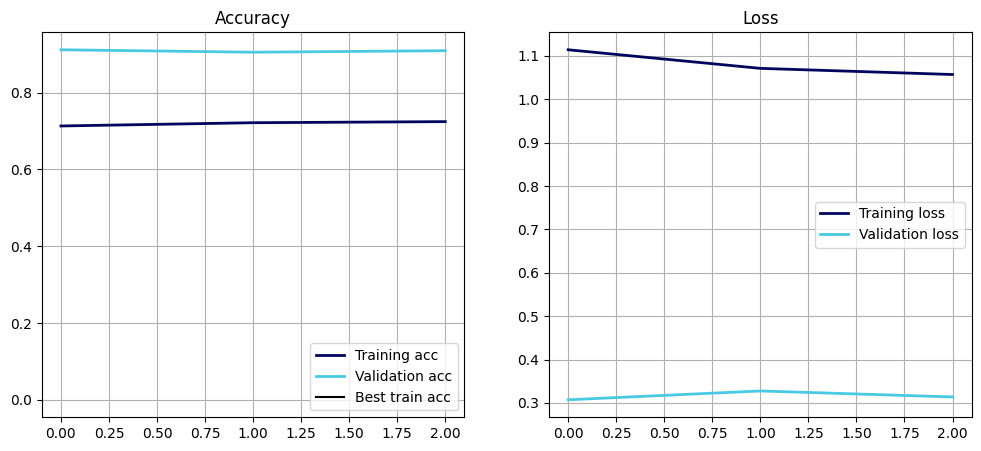

In [ ]:
plot_history(history)

**evaluating the result using the required 21 classes only**

In [ ]:
#the evaluate function measures and prints the classification accuracy of the model on a given dataset after adjusting classes to fit a 21-class problem (20 specific classes plus one "other" class).
def evaluate(model, dataloader):

  random = np.random.randint(0, len(dataloader))

  with torch.no_grad():
    model.eval()
    n_correct = 0
    n_samples = 0

    for images, labels in tqdm(dataloader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      preds = torch.argmax(torch.softmax(outputs, 1), 1)

      # Converting this problem to a problem with 21 clases only
      preds = np.array([pred.cpu() if pred < 20 else 20 for pred in preds])
      labels = np.array([label.cpu() if label < 20 else 20 for label in labels])

      n_samples += labels.shape[0]
      n_correct += (preds==labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(acc)

In [ ]:
evaluate(model,test_loader)

100%|██████████| 198/198 [03:04<00:00,  1.08it/s]

96.40792079207921


In [ ]:
#this below code provides mechanisms to work with a revised set of labels (classes_21), ensuring easy encoding and decoding between labels and integers.
class Label_encoder_21:
    def __init__(self, labels):
        labels = list(set(labels))
        self.labels = {label: idx for idx, label in enumerate(labels)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels[label]

encoder_21 = Label_encoder(classes_21)
encoder_21.get_label(0), encoder.get_idx( encoder_21.get_label(0) )

('apple_pie', 0)

**visually evaluating the results**

In [ ]:
#The visually_evaluate function aims to visually inspect the predictions made by a provided model using a random subset of images from a given DataFrame data_df.
def visually_evaluate(model, data_df):
    num_rows = 3
    num_cols = 6

    random_idx = np.random.randint(0, data_df.shape[0], num_rows*num_cols)

    # Retrieve a number of images from the dataset.
    imgs, labels = data_df.iloc[random_idx], data_df.iloc[random_idx].label
    eval_dataset = Food20(imgs, transform=test_transforms)
    eval_loader = DataLoader(eval_dataset, batch_size=num_rows*num_cols, shuffle=False)
    eval_set = next(iter(eval_loader))

    # Get predictions from model.
    model.eval()
    preds = model(eval_set[0].to(device))
    preds = torch.argmax(torch.softmax(preds, dim=1), dim=1)

    # Converting this problem to a 21 class problem
    preds = np.array([encoder_21.get_label(pred.cpu()) if pred < 20 else "other" for pred in preds])
    labels = np.array([label if encoder_21.get_idx(label) < 20 else "other" for label in labels])

    plt.figure(figsize=(20, 8))

    num_matches = 0
    for idx in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.axis("off")

        img = plt.imread(imgs.path.iloc[idx])
        plt.imshow(img)

        title = labels[idx] + " : " + preds[idx]
        title_obj = plt.title(title, fontdict={'fontsize':13})

        if labels[idx] == preds[idx]:
            num_matches += 1
            plt.setp(title_obj, color='g')
        else:
            plt.setp(title_obj, color='r')

        acc = num_matches/(idx+1)
    print("Prediction accuracy: ", int(100*acc)/100)

    return

Prediction accuracy:  1.0


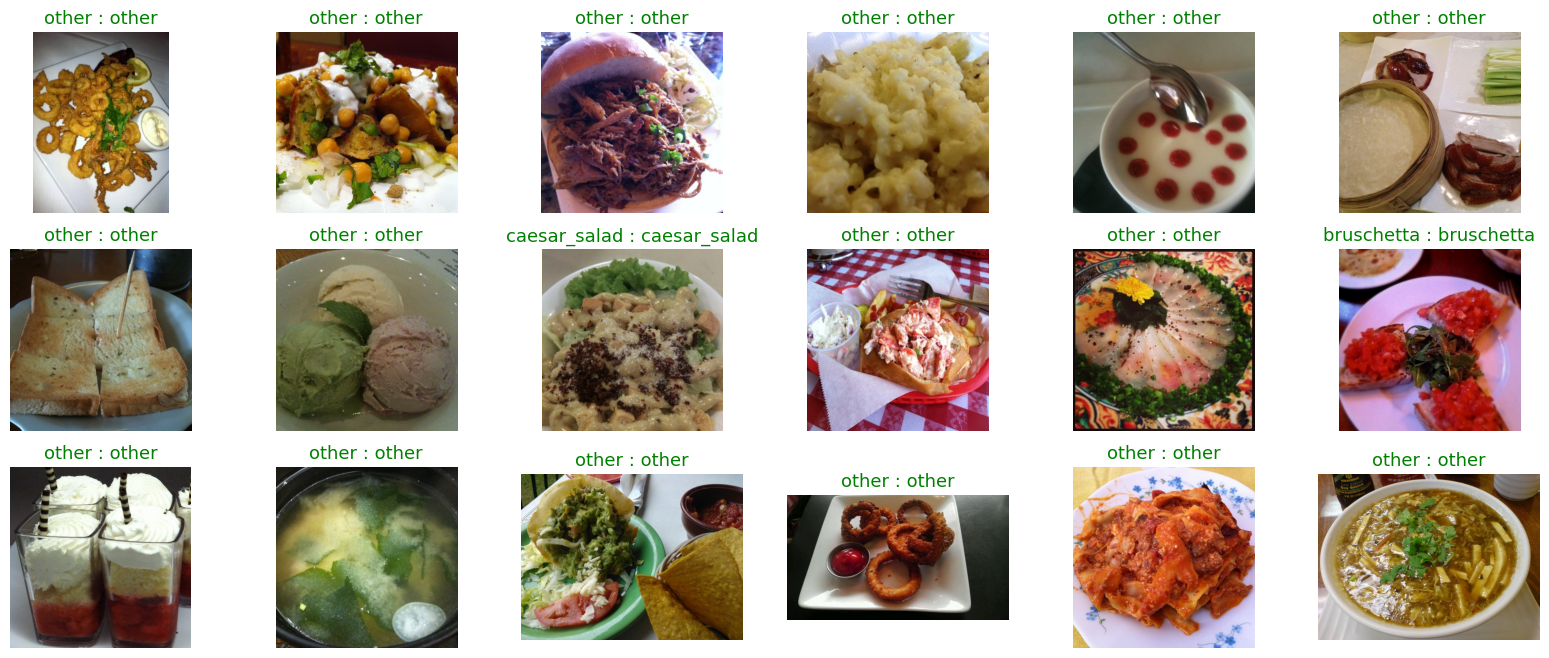

In [ ]:
visually_evaluate(model, test_imgs)

**saving the model results**

In [ ]:
#This line of code saves the best model's state dictionary (or parameters) from the training history to a file named solution.pth.
torch.save(history['best_model'], "./solution.pth")

In [ ]:
import os

if os.path.exists("./solution.pth"):
    print("solution.pth exists in the current directory.")
else:
    print("solution.pth does not exist in the current directory.")


solution.pth exists in the current directory.
